### Load input data

In [51]:
import pandas as pd

data = ["est_hourly", "est_daily", "emp_hourly", "emp_daily"]
dfs = {
    name: pd.read_csv(f"data/data_{name}.csv.bz2", index_col=0, parse_dates=True)
    for name in data
}

### Group message types with negligible contribution to network traffic into 'other' type

- Add `inout` column, corresponding to the sum of the `in` and `out` flows
- Group messages types whose maximum `inout` traffic contribution across the measurement period is below a certain threshold
- Add normalized versions of the `in` and `out` columns

In [52]:
def recategorize_by_threshold(df_orig: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    1. Compute the maximum 'inout' value for each msg_type across the entire dataset.
    2. Determine which msg_types exceed the threshold (keep_types).
    3. For sub-threshold msg_types, group by 'timestamp' to sum 'in', 'out', and 'inout'.
    4. Return a new DataFrame with columns [timestamp, msg_type, in, out, inout].
    """
    max_inout_by_type = df.groupby("msg_type")["inout"].max()
    keep_types = max_inout_by_type[max_inout_by_type > threshold].index
    df_keep = df[df["msg_type"].isin(keep_types)].copy()
    df_other = df[~df["msg_type"].isin(keep_types)].copy()
    df_keep.reset_index(inplace=True)
    df_other.reset_index(inplace=True)
    df_other_agg = df_other.groupby("timestamp", as_index=False)[
        ["in", "out", "inout"]
    ].sum()
    df_other_agg["msg_type"] = "other"
    result_df = pd.concat([df_keep, df_other_agg], ignore_index=True)
    result_df.sort_values(by=["timestamp", "msg_type"], inplace=True)
    return result_df[["timestamp", "msg_type", "in", "out", "inout"]]


thresholds = {
    "est_daily": 50_000_000,
    "est_hourly": 5_000_000,
}

for name, threshold in thresholds.items():
    df = dfs[name]
    df["inout"] = df["in"] + df["out"]
    df = recategorize_by_threshold(df, threshold)
    df["in_norm"] = df["in"] / df["inout"]
    df["out_norm"] = df["out"] / df["inout"]
    dfs[name] = df

# Validation

### Hourly (IBD)

### Daily (excluding IBD)

/var/folders/m2/sp1y0c8x2sq7fcfkd6jttshm0000gn/T/ipykernel_26497/2813825234.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap("viridis", num_msg_types)  # Discretize into N segments
/var/folders/m2/sp1y0c8x2sq7fcfkd6jttshm0000gn/T/ipykernel_26497/2813825234.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap("jet", num_msg_types)  # Discretize into N segments
/var/folders/m2/sp1y0c8x2sq7fcfkd6jttshm0000gn/T/ipykernel_26497/2813825234.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[na

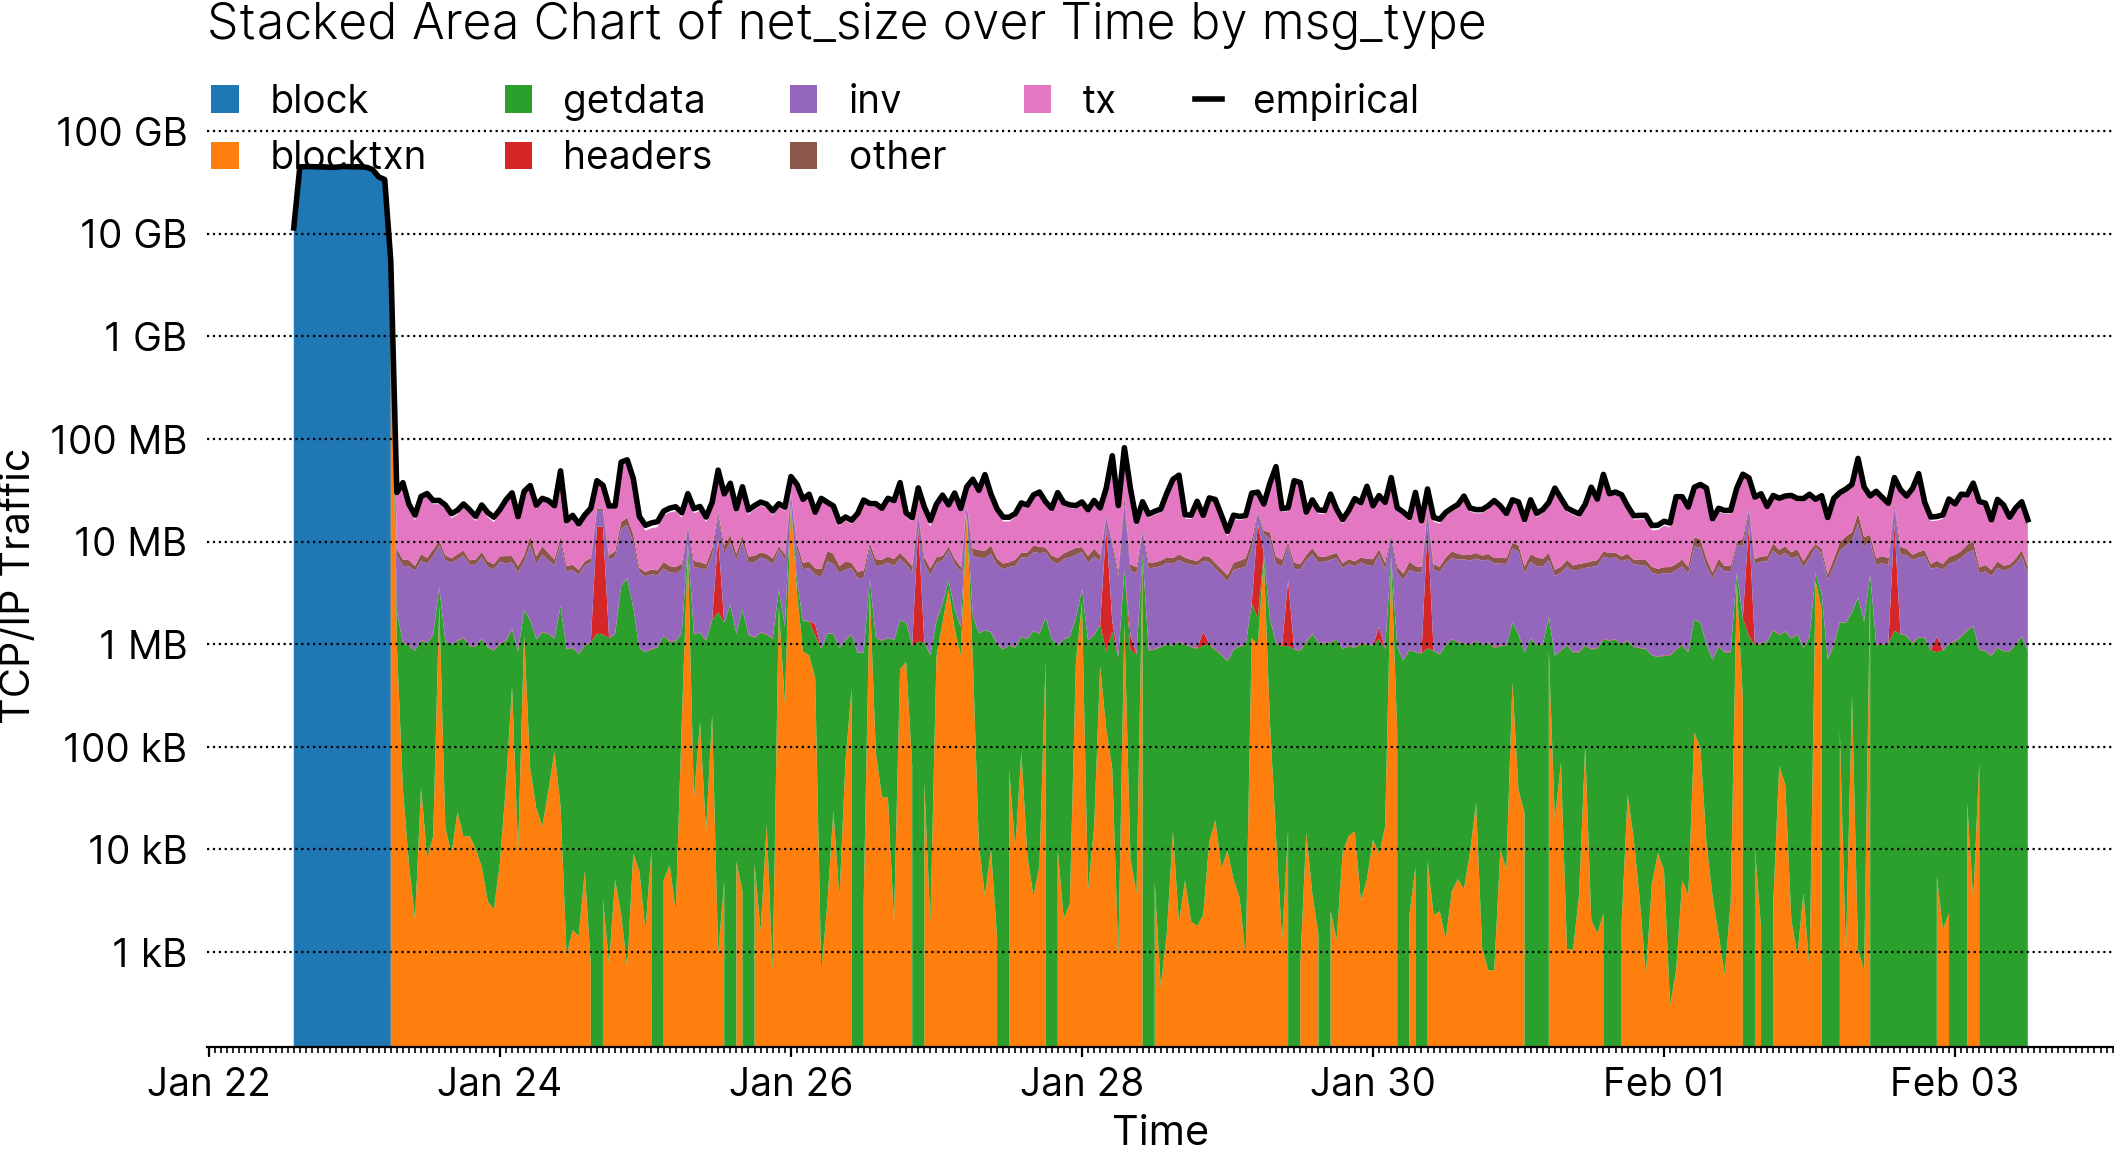

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import EngFormatter


# Example data pivot for stacking:
# We assume dfs["est_hourly"] has columns ["timestamp", "msg_type", "inout"].
df_est = dfs["est_hourly"].copy()

# Pivot so that msg_type values become separate columns
df_pivot = df_est.pivot(index="timestamp", columns="msg_type", values="inout").fillna(0)

# X-values for plotting
# df_pivot.index = pd.to_datetime(df_pivot.index)
x = df_pivot.index

# Y-values for each msg_type (list of columns for stackplot)
y_values = [df_pivot[col] for col in df_pivot.columns]

# Create the figure and axis
fig, ax = plt.subplots()

# --- STACKED AREA ---
# stackplot expects arrays, so unpack the list of Series

msg_types = df_pivot.columns

num_msg_types = len(msg_types)
viridis = plt.cm.get_cmap("viridis", num_msg_types)  # Discretize into N segments
viridis = plt.cm.get_cmap("jet", num_msg_types)  # Discretize into N segments
colors = [viridis(i) for i in range(num_msg_types)]

tab10 = plt.cm.get_cmap("tab10")
colors = [tab10(i % 10) for i in range(num_msg_types)]

ax.stackplot(x, *y_values, labels=df_pivot.columns, colors=colors)

# --- ADD LINE FOR emp_hourly ---
# Here we sum the "in" and "out" columns as in your Plotly code:
emp_line = dfs["emp_hourly"]["in"] + dfs["emp_hourly"]["out"]
ax.plot(
    dfs["emp_hourly"].index, emp_line, color="black", linewidth=2, label="empirical"
)

# --- TITLES & LABELS ---
ax.set_title("Stacked Area Chart of net_size over Time by msg_type")
ax.set_xlabel("Time")
ax.set_ylabel("TCP/IP Traffic")

# --- LEGEND ---
# stackplot doesn't automatically create handles for the stacked series,
# but the labels are recognized if you pass them to stackplot.
# You also have one extra line label, so we can place everything together:
# ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4, title="Message Type")
ax.legend(ncol=5, title="")

ax.set_yscale("log")
formatter = EngFormatter(unit="B")
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))


plt.tight_layout()
plt.show()

# DAILY

/var/folders/m2/sp1y0c8x2sq7fcfkd6jttshm0000gn/T/ipykernel_26497/1714388611.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap("viridis", num_msg_types)  # Discretize into N segments
/var/folders/m2/sp1y0c8x2sq7fcfkd6jttshm0000gn/T/ipykernel_26497/1714388611.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap("jet", num_msg_types)  # Discretize into N segments
/var/folders/m2/sp1y0c8x2sq7fcfkd6jttshm0000gn/T/ipykernel_26497/1714388611.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[na

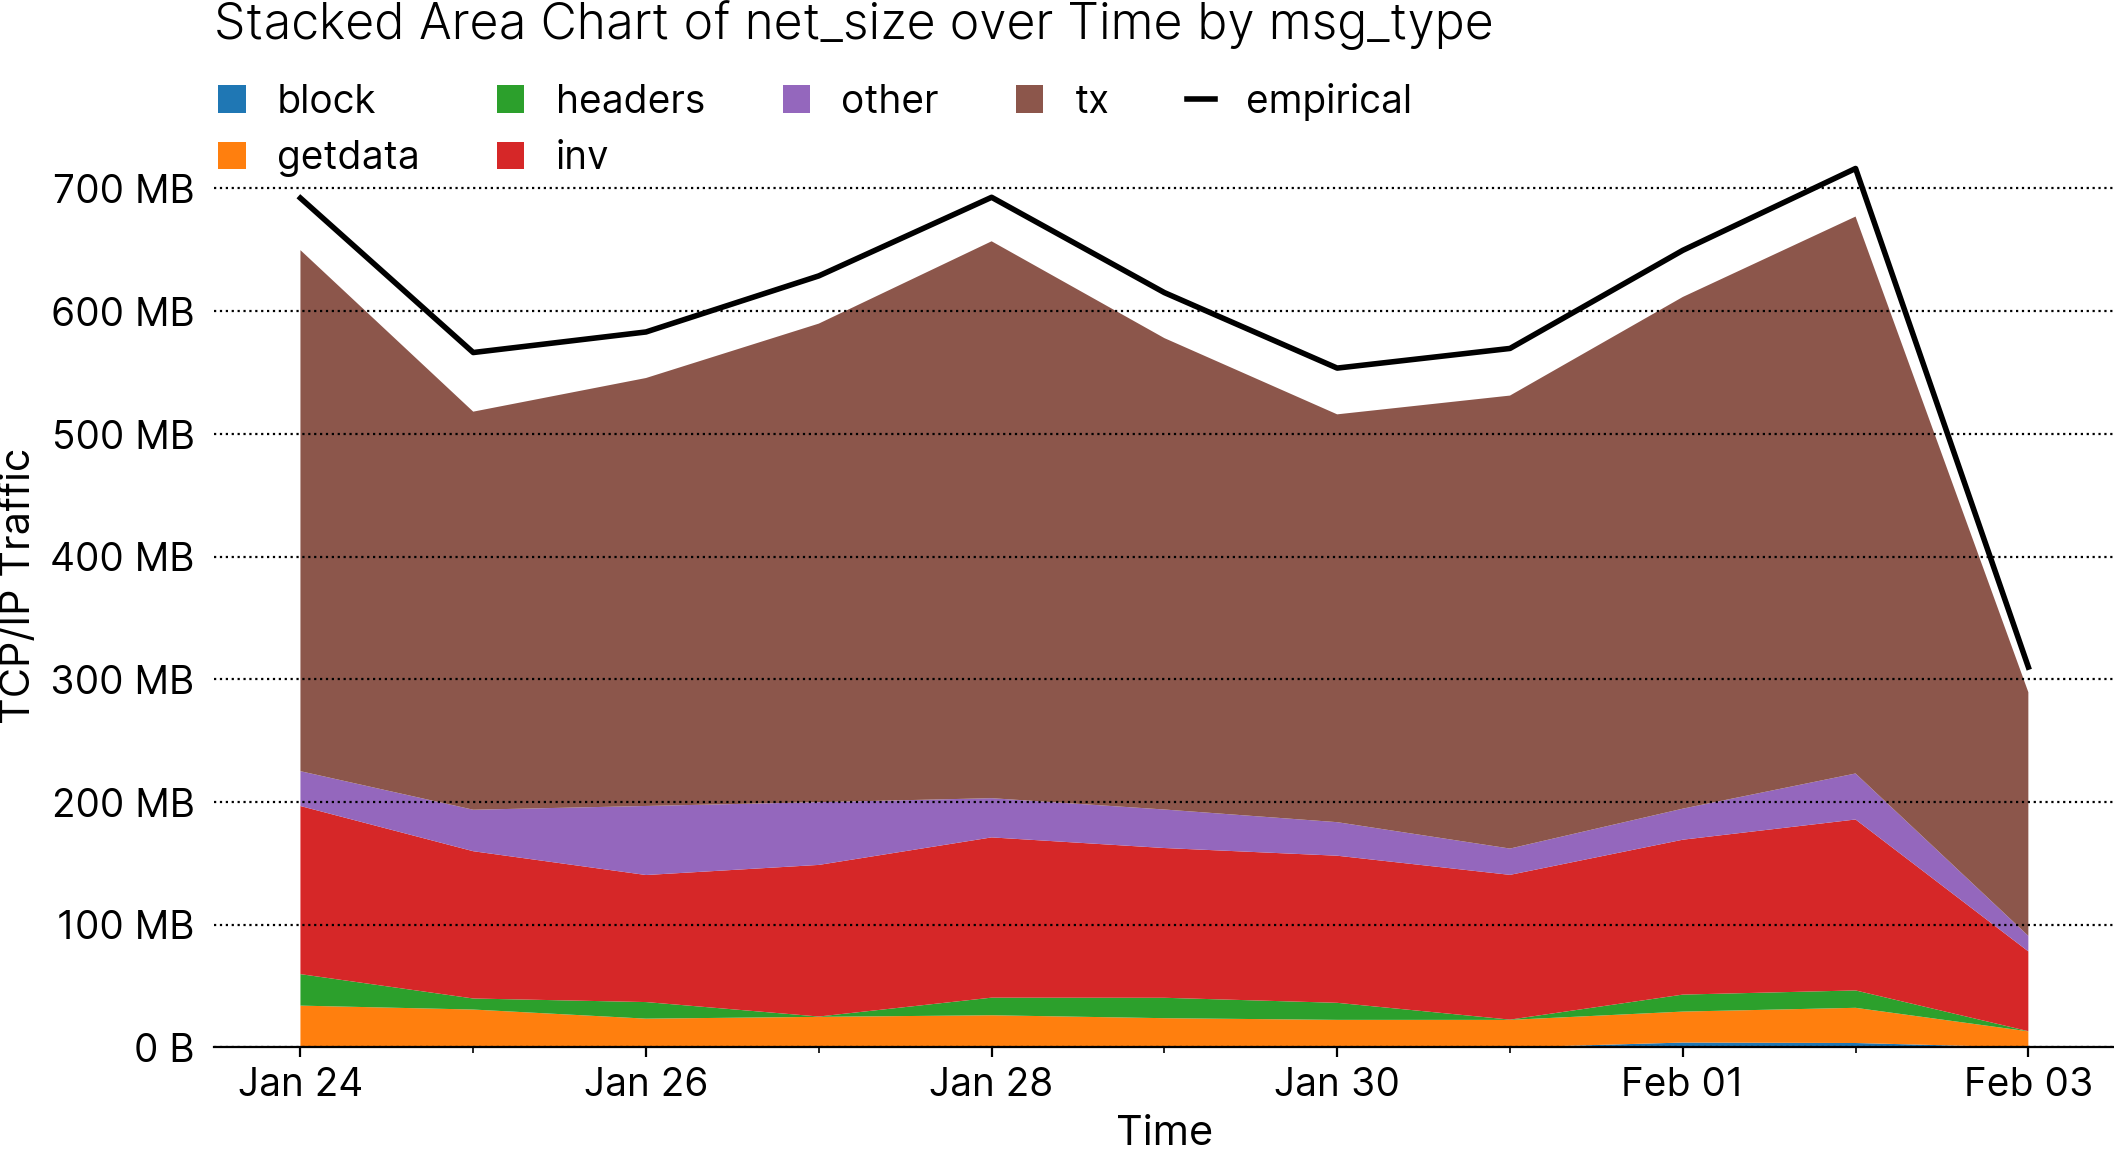

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import EngFormatter


# Example data pivot for stacking:
# We assume dfs["est_daily"] has columns ["timestamp", "msg_type", "inout"].
df_est = dfs["est_daily"].copy()

# Pivot so that msg_type values become separate columns
df_pivot = df_est.pivot(index="timestamp", columns="msg_type", values="inout").fillna(0)
df_pivot = df_pivot["2025-01-24":]

# X-values for plotting
# df_pivot.index = pd.to_datetime(df_pivot.index)
x = df_pivot.index

# Y-values for each msg_type (list of columns for stackplot)
y_values = [df_pivot[col] for col in df_pivot.columns]

# Create the figure and axis
fig, ax = plt.subplots()

# --- STACKED AREA ---
# stackplot expects arrays, so unpack the list of Series

msg_types = df_pivot.columns

num_msg_types = len(msg_types)
viridis = plt.cm.get_cmap("viridis", num_msg_types)  # Discretize into N segments
viridis = plt.cm.get_cmap("jet", num_msg_types)  # Discretize into N segments
colors = [viridis(i) for i in range(num_msg_types)]

tab10 = plt.cm.get_cmap("tab10")
colors = [tab10(i % 10) for i in range(num_msg_types)]

ax.stackplot(x, *y_values, labels=df_pivot.columns, colors=colors)

# --- ADD LINE FOR emp_daily ---
# Here we sum the "in" and "out" columns as in your Plotly code:
emp_line = (
    dfs["emp_daily"]["in"]["2025-01-24":] + dfs["emp_daily"]["out"]["2025-01-24":]
)
ax.plot(
    dfs["emp_daily"]["2025-01-24":].index,
    emp_line,
    color="black",
    linewidth=2,
    label="empirical",
)

# --- TITLES & LABELS ---
ax.set_title("Stacked Area Chart of net_size over Time by msg_type")
ax.set_xlabel("Time")
ax.set_ylabel("TCP/IP Traffic")

# --- LEGEND ---
# stackplot doesn't automatically create handles for the stacked series,
# but the labels are recognized if you pass them to stackplot.
# You also have one extra line label, so we can place everything together:
# ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4, title="Message Type")
ax.legend(ncol=5, title="")

# ax.set_yscale("log")
formatter = EngFormatter(unit="B")
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))


plt.tight_layout()
plt.show()

## Plot daily in (absolute)

In [14]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.area(
    dfs["est_daily"],
    x="timestamp",
    y="in",
    color="msg_type",
    title="Stacked Area Chart of net_size over Time by msg_type",
    labels={"net_size": "Net Size", "hour_groups": "Time", "msg_type": "Message Type"},
)

fig.add_trace(
    go.Scatter(
        x=dfs["emp_daily"].index,
        y=dfs["emp_daily"]["in"],
        mode="lines",
        name="emp_daily",
        line=dict(color="black", width=2),
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Net Size",
    legend_title="Message Type",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
    ),
)
fig.update_yaxes(tickformat=".2s", ticksuffix="B")
fig.show()

## Plot out (absolute)

In [6]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.area(
    dfs["est_daily"],
    x="timestamp",
    y="out",
    color="msg_type",
    title="Stacked Area Chart of net_size over Time by msg_type",
    labels={"net_size": "Net Size", "hour_groups": "Time", "msg_type": "Message Type"},
)

fig.add_trace(
    go.Scatter(
        x=dfs["emp_daily"].index,
        y=dfs["emp_daily"]["out"],
        mode="lines",
        name="emp_daily",
        line=dict(color="black", width=2),
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Net Size",
    legend_title="Message Type",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
    ),
)
fig.update_yaxes(tickformat=".2s", ticksuffix="B")
fig.show()

## inout

In [7]:
dfs["emp_daily"]

,in,out
timestamp,,
2025-01-22 00:00:00+00:00,410699276288,4159172666
2025-01-23 00:00:00+00:00,249253426316,2389922496
2025-01-24 00:00:00+00:00,428332327,263730602
2025-01-25 00:00:00+00:00,348672318,217543569
2025-01-26 00:00:00+00:00,409759999,173218424
2025-01-27 00:00:00+00:00,423069813,205597017
2025-01-28 00:00:00+00:00,461584199,231108457
2025-01-29 00:00:00+00:00,409576936,205458073
2025-01-30 00:00:00+00:00,366251490,187277323


In [8]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.area(
    dfs["est_daily"],
    x="timestamp",
    y="inout",
    color="msg_type",
    title="Stacked Area Chart of net_size over Time by msg_type",
    labels={"net_size": "Net Size", "hour_groups": "Time", "msg_type": "Message Type"},
)

fig.add_trace(
    go.Scatter(
        x=dfs["emp_daily"].index,
        y=dfs["emp_daily"]["in"] + dfs["emp_daily"]["out"],
        mode="lines",
        name="emp_daily",
        line=dict(color="black", width=2),
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Net Size",
    legend_title="Message Type",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
    ),
)
fig.update_yaxes(tickformat=".2s", ticksuffix="B")
fig.show()

# In/out hourly

In [15]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.area(
    dfs["est_hourly"],
    x="timestamp",
    y="inout",
    color="msg_type",
    title="Stacked Area Chart of net_size over Time by msg_type",
    labels={"net_size": "Net Size", "hour_groups": "Time", "msg_type": "Message Type"},
    log_y=True,
)

fig.add_trace(
    go.Scatter(
        x=dfs["emp_hourly"].index,
        y=dfs["emp_hourly"]["in"] + dfs["emp_hourly"]["out"],
        mode="lines",
        name="emp_hourly",
        line=dict(color="black", width=2),
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Net Size",
    legend_title="Message Type",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
    ),
)
fig.update_yaxes(tickformat=".2s", ticksuffix="B")
fig.show()

## Out hourly (should peak near getrawaddrman?)

In [11]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.area(
    dfs["est_hourly"],
    x="timestamp",
    y="inout",
    color="msg_type",
    title="Stacked Area Chart of net_size over Time by msg_type",
    labels={"net_size": "Net Size", "hour_groups": "Time", "msg_type": "Message Type"},
)

fig.add_trace(
    go.Scatter(
        x=dfs["emp_hourly"].index,
        y=dfs["emp_hourly"]["in"] + dfs["emp_hourly"]["out"],
        mode="lines",
        name="emp_hourly",
        line=dict(color="black", width=2),
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Net Size",
    legend_title="Message Type",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
    ),
)
fig.update_yaxes(tickformat=".2s", ticksuffix="B")
fig.show()